In [86]:
from scipy.optimize import leastsq
import numpy as np
import matplotlib.pyplot as plt 

Defino funciones y parametros que voy a usar luego. Dist me calcula la distancia euclediana entre dos puntos. Func es el modelo lineal que paso como parametro al LeastSq. 

In [87]:
def dist(p1,p2):
    cant1 = np.abs(p1[0] - p2[0])
    cant2 = np.abs(p1[1] - p2[1])
    dist = np.sqrt((cant1**2) + (cant2**2))
    return dist

def func(params, x, y):
    a, b = params[0], params[1]
    residual = y-(a*x+b)
    return residual

params = [1, 1]

Defino los puntos del hexagono. Me genero un punto al azar que vive dentro del hexagono. Grafico

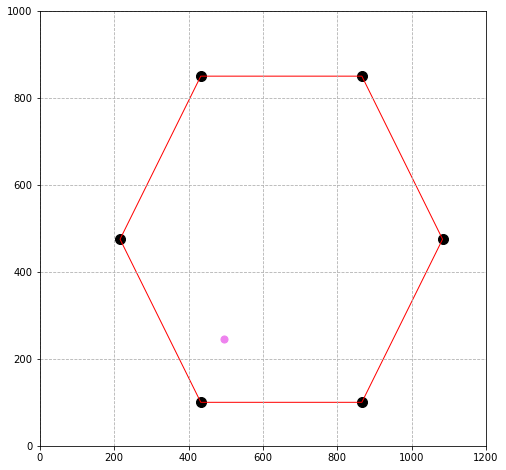

In [95]:
points = [[433,100],[866,100],[1083,475],[866,850],[433,850],[216,475]]
pointsx,pointsy = [433,866,1083,866,433,216] , [100,100,475,850,850,475]
randx,randy = np.random.uniform(433,866),np.random.uniform(100,850)


distancias = []
for i in range(len(points)):
    distancias.append(dist([randx,randy],points[i]))
    

plt.figure(figsize=(8,8))
polygon = plt.Polygon(points,fill=None,edgecolor='r')
plt.gca().add_patch(polygon)
plt.xlim(0,1200)
plt.ylim(0,1000)
plt.scatter(randx,randy,s = 50,c='violet')
plt.scatter(pointsx,pointsy,s = 100,c = 'black')
plt.grid(linestyle='--')
plt.show()




Chequeo las distancias entre los verrtices para que sean todas aproximadamente 433. 

In [89]:
for i in range(len(points)):
    if i == len(points)-1:
        print(dist(points[0],points[len(points)-1]))
    if i < len(points)-1:
        print(dist(points[i],points[i+1]))

433.0
433.2597373400856
433.2597373400856
433.0
433.2597373400856
433.2597373400856


Genero los puntos y a partir de la relacion lineal.

In [119]:
y = 100 - (100/433)*np.asarray(distancias)
sigma = 5

Genero 1000 puntos de y al azar y obtengo los parametros de la recta que mejor los ajustan.

In [123]:
a1 = []
a2 = []

for i in range(1000):
    valores_y = (np.random.normal(loc = y, scale = sigma))
    a1.append(leastsq(func, params, (np.asarray(distancias), valores_y))[0][1])
    a2.append(leastsq(func, params, (np.asarray(distancias), valores_y))[0][0])
    
print(np.mean(a1),np.mean(a2),-100/433,100)

99.96872814598898 -0.23074876726807175 -0.23094688221709006 100


Grafico los histogramas de la pendiente y la ordenada

Text(0.5, 0, '$a_{2}$')

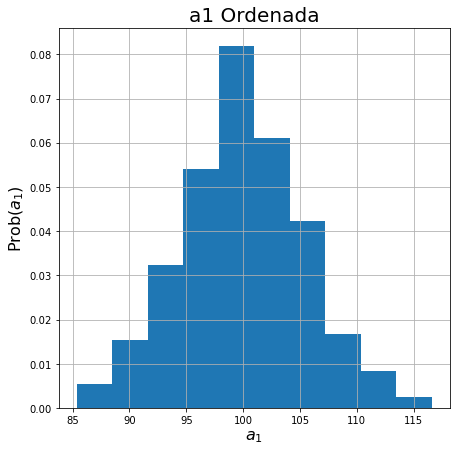

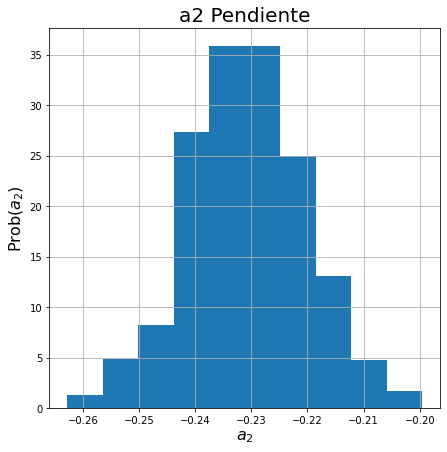

In [127]:
plt.figure(figsize=(7,7))
plt.hist(a1,density=True)
plt.title('a1 Ordenada',size = 20)
plt.grid()
plt.ylabel('Prob($a_{1}$)',size = 16)
plt.xlabel('$a_{1}$',size = 16)



plt.figure(figsize=(7,7))
plt.hist(a2,density=True)
plt.title('a2 Pendiente',size = 20)
plt.grid()
plt.ylabel('Prob($a_{2}$)',size = 16)
plt.xlabel('$a_{2}$',size = 16)